# Facial Keypoints Detection - Yüz Anahtar Noktalarının Tespiti

Bu Kaggle yarışması, yüz görüntülerinde belirli noktaların konumlarını tahmin etmeyi amaçlamaktadır. Bu noktalar, çeşitli yüz özelliklerine karşılık gelir ve görev, bu noktaları bir yüz resminde otomatik olarak bulabilen bir algoritma oluşturmaktır.

### Amaç:
Bu yarışmanın başlıca amaçları şunlardır:
1. **Yüzleri Takip Etme:** Görüntülerde ve videolarda yüzleri tespit etme ve takip etme.
2. **Yüz İfadelerini Analiz Etme:** Anahtar nokta konumlarına dayalı olarak yüz ifadelerini analiz etme.
3. **Tıbbi Teşhis:** Tıbbi teşhis için anormallik gösteren yüz işaretlerini tespit etme.
4. **Biometrik / Yüz Tanıma:** Biyometrik ve yüz tanıma sistemlerinde bir yapı taşı olarak katkıda bulunma.

### Zorluklar:
- **Zorlu Bir Sorun:** Yüz anahtar noktalarını tespit etmek, bireyler arasındaki yüz özelliklerindeki değişkenlik nedeniyle zorlu bir problemdir; bu değişkenlik 3D duruş, boyut, konum, görüntüleme açısı ve aydınlatma koşullarından kaynaklanmaktadır.
- **Değişkenlik:** Bir birey için bile, yüz özelliklerinde büyük bir değişkenlik bulunmaktadır.
- **Gelişim İçin Fırsatlar:** Bilgisayar görüşü araştırmaları bu zorlukları ele almak konusunda ilerleme kaydetmiş olsa da, hala iyileştirme fırsatları bulunmaktadır.

### Veri Kümesi ve Eğitim:
- **Veri Kaynağı:** Bu yarışma için veri seti Montreal Üniversitesi'nden Dr. Yoshua Bengio tarafından sağlanmıştır.
- **Eğitim:** Başlangıç yapmak için katılımcılara bir R eğitimi ve referans veri kümesi sağlanmıştır.

### Değerlendirme Metriği:
- **Kök Ortalama Kare Hata (RMSE):** Katılımcılar, gönderimlerini RMSE'ye dayalı olarak değerlendirir. RMSE, büyük hataları Ortalama Mutlak Hata'ya göre cezalandırır.

### Gönderim Talimatları:
- Katılımcılar, gönderi dosya biçimini (submissionFileFormat.csv) veri sayfasından indirmelidir.
- Gönderi dosyası, Row Id, Image Id, Feature Name ve Location (belirli özellik için x veya y koordinatı) gibi sütunları içerir.
- Katılımcılardan her bir görüntü için tüm 30 özelliği tespit etmeleri gerekmez, çünkü bazı görüntülerde daha az anahtar nokta bulunabilir.

### Gönderi Dosyasının Ana Bileşenleri:
- **Row Id:** Satır için tamsayı kimliği.
- **Image Id:** Görüntü için tamsayı kimliği (test setinde 1783 görüntü bulunmaktadır).
- **Feature Name:** Yüz anahtar noktasını tanımlayan dize (örneğin, sol_göz_merkezi_x).
- **Location:** Belirtilen özelliğin x veya y koordinatı, tahmin edilecek değer.

Katılımcılar, sağlanan eğitim verilerine dayanarak bu anahtar nokta konumlarını doğru bir şekilde tahmin edebilen algoritmalar geliştirmelidirler.

Bu yarışma, katılımcılara bilgisayar görüşü tekniklerini uygulama ve yüz anahtar nokta tespiti için algoritmalar geliştirme fırsatı sunar, bu da çeşitli alanlarda potansiyel uygulamalara sahiptir.

In [5]:
from google.colab import files

# Kaggle API anahtar dosyanızı seçin ve yükleyin
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [6]:
!pip install kaggle

# Kaggle API anahtarını Colab'a taşıyın
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Yarışmanın adını ve veri seti adını belirtin
competition_name = "facial-keypoints-detection"


# Veri setini indirin
!kaggle competitions download -c facial-keypoints-detection

 96% 73.0M/76.3M [00:00<00:00, 142MB/s]
100% 76.3M/76.3M [00:00<00:00, 115MB/s]


In [7]:
import zipfile
import os

# İndirilen zip dosyasının adını belirtin (bu adı kendi indirdiğiniz dosyanın adına göre güncelleyin)
zip_file_name = "facial-keypoints-detection.zip"

# Çıkartmak istediğiniz dizini belirtin
extract_path = "/content/facial-keypoints-detection"

# Zip dosyasını çıkartın
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Çıkartılan dosyaların listesini göster
extracted_files = os.listdir(extract_path)
print("Çıkartılan Dosyalar:", extracted_files)


Çıkartılan Dosyalar: ['SampleSubmission.csv', 'training.zip', 'test.zip', 'IdLookupTable.csv']


**KÜTÜPHANELERİMİZİ İMPORT EDİYORUZ VE VERİMİZİ İNDİRİYORUZ**

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU, Conv2D, Dropout, Dense, Flatten, Activation, MaxPooling2D, BatchNormalization
# Geri kalan kod buraya eklenir
from keras.models import Sequential, Model

In [9]:
!ls "/content/facial-keypoints-detection/"

IdLookupTable.csv  SampleSubmission.csv  test.zip  training.zip


In [10]:
# Çıkartma işlemi için zip dosyalarının adlarını belirtin
zip_files = ['training.zip', 'test.zip']

# Dosyaların çıkartılacağı dizini belirtin
extract_path = "/content/facial-keypoints-detection/"

# Her bir zip dosyasını çıkartın
for zip_file in zip_files:
    zip_file_path = os.path.join(extract_path, zip_file)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Çıkartılan dosyaların listesini göster
extracted_files = os.listdir(extract_path)
print("Çıkartılan Dosyalar:", extracted_files)

Çıkartılan Dosyalar: ['SampleSubmission.csv', 'training.zip', 'training.csv', 'test.zip', 'IdLookupTable.csv', 'test.csv']


**ZİP DOSYASINDAN ÇIKARDIĞIMIZ VERİLERİ İŞLEMEK İÇİN TANIMLIYORUZ.**

In [11]:
dftrain = pd.read_csv('/content/facial-keypoints-detection/training.csv')
dftest = pd.read_csv('/content/facial-keypoints-detection/test.csv')

In [12]:
print(dftrain.shape)
print(dftest.shape)

(7049, 31)
(1783, 2)


In [13]:
dftest.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


**Data framemizin Train yani eğitim dosyasından işlemeye başlıyoruz.**

In [14]:
dftrain.head(3)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...


Son sutundaki (image) aslında orijinalde 96x96 piksel boyutlarında bir görüntü olduğunu belirtiyor. Ancak, bu görüntülerin, işlem kolaylığı veya belki de başka nedenlerle, düzleştirildiğini ve her birinin bir dize olarak temsil edildiğini ifade ediyor.
Bu düzleştirme işlemi, orijinal 96x96 piksel matrisi sıralı bir dize haline getirir. Bu dizide, her bir sayı, orijinal görüntünün belirli bir pikselinin değerini temsil eder. Bu, görüntüyü tek bir satırda ifade eder.
Bu dizinin toplam uzunluğu, 96x96 = 9216'dir. Bu, her bir görüntünün 9216 piksele sahip bir vektörle temsil edildiği anlamına gelir. Bu vektör, makine öğrenimi algoritmalarına veya derin öğrenme modellerine girdi olarak verilebilir. Ancak, bu vektörü yeniden 96x96 boyutlarına dönüştürerek orijinal görüntüyü elde etmek mümkündür.

In [15]:
dftrain.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [16]:
dftrain.corr(numeric_only=True).T

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
left_eye_center_x,1.000000,0.029908,0.274459,-0.154728,0.856572,0.022211,0.879976,0.062128,0.308649,-0.104698,...,0.457468,0.192274,0.422891,0.284087,-0.008382,0.202842,0.260753,0.151302,0.374314,0.265655
left_eye_center_y,0.029908,1.000000,0.259012,0.346331,0.065749,0.926728,-0.013411,0.956066,0.101996,0.537101,...,-0.166891,0.333053,-0.340755,0.480924,-0.392434,0.219366,-0.425576,0.251472,-0.379980,0.130062
right_eye_center_x,0.274459,0.259012,1.000000,0.067621,0.294550,0.127367,-0.024408,0.060942,0.817895,0.090214,...,0.402189,0.024502,0.061124,-0.172144,0.424439,-0.215123,0.308889,-0.109026,0.319541,-0.251105
right_eye_center_y,-0.154728,0.346331,0.067621,1.000000,-0.149295,0.531960,-0.144389,0.221829,0.055758,0.923050,...,0.182866,0.329233,0.312434,0.098019,0.257956,0.397645,0.294145,0.198499,0.344010,0.044597
left_eye_inner_corner_x,0.856572,0.065749,0.294550,-0.149295,1.000000,-0.021444,0.653318,0.080430,0.267661,-0.172852,...,0.387317,-0.054712,0.287427,0.156495,0.145968,0.046439,0.322217,-0.083635,0.242669,0.303769
left_eye_inner_corner_y,0.022211,0.926728,0.127367,0.531960,-0.021444,1.000000,0.010531,0.869743,0.150281,0.710354,...,-0.091006,0.426897,-0.211855,0.493657,-0.335989,0.327081,-0.315929,0.387311,-0.367069,0.308555
left_eye_outer_corner_x,0.879976,-0.013411,-0.024408,-0.144389,0.653318,0.010531,1.000000,0.054156,0.316254,-0.094245,...,0.179189,0.165361,0.507755,0.325291,-0.136411,0.263466,0.229154,0.292129,0.176392,0.332880
left_eye_outer_corner_y,0.062128,0.956066,0.060942,0.221829,0.080430,0.869743,0.054156,1.000000,0.050529,0.373183,...,-0.176047,0.222928,-0.392594,0.506364,-0.462165,0.183239,-0.494482,0.216060,-0.561581,0.329316
right_eye_inner_corner_x,0.308649,0.101996,0.817895,0.055758,0.267661,0.150281,0.316254,0.050529,1.000000,0.124023,...,0.377931,0.118548,0.262597,-0.054888,0.262056,-0.094748,0.369890,0.109785,0.309453,-0.230177
right_eye_inner_corner_y,-0.104698,0.537101,0.090214,0.923050,-0.172852,0.710354,-0.094245,0.373183,0.124023,1.000000,...,0.053212,0.356647,0.237858,0.225398,0.108121,0.449346,0.176403,0.354693,0.203002,0.164086


In [17]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

Bu veri çerçevesi, yüzün çeşitli anahtar noktalarının (facial keypoints) X ve Y koordinatlarını içermektedir. Her bir sütun, belirli bir anahtar noktanın X veya Y koordinatını temsil eder. İşte bazı örnek sütunlar ve açıklamalar:

- `left_eye_center_x` ve `left_eye_center_y`: Sol göz merkezinin X ve Y koordinatları.
- `right_eye_center_x` ve `right_eye_center_y`: Sağ göz merkezinin X ve Y koordinatları.
- `nose_tip_x` ve `nose_tip_y`: Burun ucunun X ve Y koordinatları.
- `mouth_center_top_lip_x` ve `mouth_center_top_lip_y`: Üst dudak merkezinin X ve Y koordinatları.
- `mouth_center_bottom_lip_x` ve `mouth_center_bottom_lip_y`: Alt dudak merkezinin X ve Y koordinatları.

Ve diğer birçok benzer sütunlar. Her bir sütun, o belirli yüz anahtar noktasının X veya Y koordinatının bulunduğu konumu temsil eder. Bu sütunlar, modelin eğitimi sırasında giriş (input) özellikleri olarak kullanılacak ve modelin çıkışını (output), yüzün bu anahtar noktalarının doğru konumlarını tahmin etmek olacaktır.

Ayrıca, son sütun olan `Image`, yüz resminin piksellerini içeren bir string'dir. Bu string, orijinal 96x96 boyutundaki bir resmin piksellerinin düzleştirilmiş hali olarak verilmiştir. Bu pikselleri kullanarak model, yüzün anahtar noktalarını tahmin etmeye çalışacaktır.

In [18]:
dftrain.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

<Axes: >

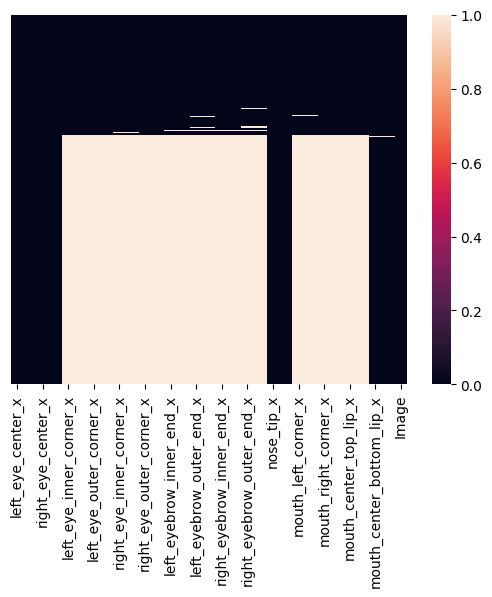

In [19]:
sns.heatmap(dftrain.isnull(),yticklabels = False, cbar ='BuPu')
# Boş verileri açık renk ile görüyoruz.

In [20]:
# Eksik verilerimiz çok fazla silersek veri kaybı olacak o yüzden mean, median veya önceki değer ile doldurabiliriz
# dftrain.fillna(method = 'ffill', inplace=True) yada
# dftrain = dftrain.fillna(dftrain.mean())
#dftrain.fillna(dftrain.mean(), inplace=True) bu işlem çok uzun üsrüp makine yeterli olmadığı için sutunları tek tek seçip ortalama ile dolduruyoruz.

# Belirli sütunları seç
selected_columns = ["left_eye_inner_corner_x", "left_eye_inner_corner_y", "left_eye_outer_corner_x",
                     "left_eye_outer_corner_y", "right_eye_inner_corner_x", "right_eye_inner_corner_y",
                     "right_eye_outer_corner_x", "right_eye_outer_corner_y", "left_eyebrow_inner_end_x",
                     "left_eyebrow_inner_end_y", "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y",
                     "right_eyebrow_inner_end_x", "right_eyebrow_inner_end_y", "right_eyebrow_outer_end_x",
                     "right_eyebrow_outer_end_y", "nose_tip_x", "nose_tip_y", "mouth_left_corner_x",
                     "mouth_left_corner_y", "mouth_right_corner_x", "mouth_right_corner_y",
                     "mouth_center_top_lip_x", "mouth_center_top_lip_y"]

# Seçilen sütunlardaki eksik değerleri ortalamayla doldur
dftrain[selected_columns] = dftrain[selected_columns].fillna(dftrain[selected_columns].mean())

In [21]:
dftrain.fillna(method = 'ffill', inplace=True)
# aslında boş verileri mean ile doldurmak istedik fakat eğitirken veri saptığı için bir önceki değer ile doldurduk.

In [22]:
dftrain.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

**Modeli Eğitime hazırlıyoruz**

In [23]:
m = len(dftrain)
img_height = 96  # Görüntü yüksekliği
img_width = 96   # Görüntü genişliği

# Boş bir liste oluşturuyoruz, görüntüler buraya eklenecek
img = []
# Her bir satır üzerinde dönerek, 'Image' sütunundaki piksel değerlerini çıkartıyoruz
# Eğer piksel değerlerinde boşluk varsa (null değeri), bunları sıfır ile değiştiriyoruz
for i in range(m):
    face_pixel = np.array(dftrain['Image'][i].split(' '), dtype='float')
    #'Image' sütunundaki piksel değerlerini alır ve bunları bir diziye dönüştürür. Boşluklara göre ayırır.
    face_pixel = np.reshape(face_pixel, (img_height, img_width, 1))
    #Yeni şekil (96x96x1) ile görüntüyü şekillendirir.

    # Piksel değerlerini 0 ile 255 arasında normalleştiriyoruz
    face_pixel /= 255

    # Yeni şekillendirilmiş görüntüyü listeye ekliyoruz
    img.append(face_pixel)

# Listeyi numpy dizisine dönüştürüyoruz
img = np.array(img)

In [24]:
x = img
dftrain.drop('Image', axis=1, inplace=True)
y = []

for i in range(len(dftrain)):
    y_i = dftrain.iloc[i, :].values
    y.append(y_i)

y = np.array(y, dtype='float')
x.shape, y.shape

((7049, 96, 96, 1), (7049, 30))

In [25]:
y

array([[66.03356391, 39.00227368, 30.22700752, ..., 72.93545865,
        43.13070677, 84.48577444],
       [64.33293617, 34.9700766 , 29.9492766 , ..., 70.26655319,
        45.46791489, 85.48017021],
       [65.05705263, 34.90964211, 30.90378947, ..., 70.19178947,
        47.27494737, 78.65936842],
       ...,
       [66.69073171, 36.84522146, 31.66641951, ..., 75.96359236,
        49.46257171, 78.11712   ],
       [70.96508235, 39.85366588, 30.54328471, ..., 75.96359236,
        50.06518588, 79.58644706],
       [66.93831111, 43.42450963, 31.09605926, ..., 75.96359236,
        45.90048   , 82.7730963 ]])

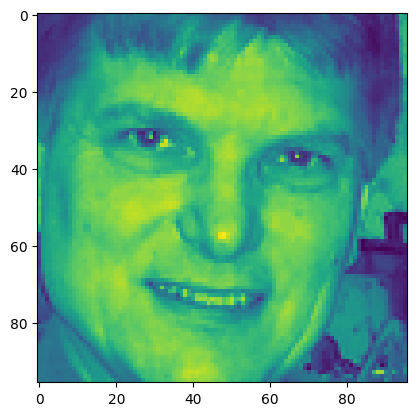

In [26]:
plt.imshow(x[1888])
plt.show()

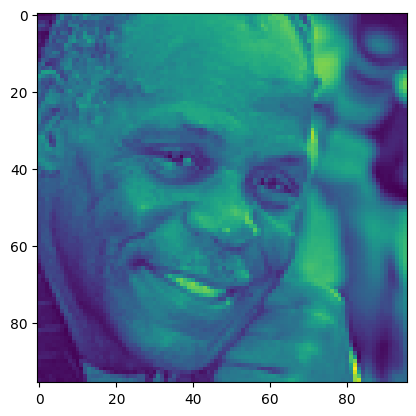

In [27]:
plt.imshow(x[1959])
plt.show()

**Çıkan görüntülerde yüz koordinatlarını işaretleyeceğiz.**

In [28]:
def image_with_keypoints(df, index):
    image = plt.imshow(x[index], cmap='gray')
    l = []
    for i in range(1, 31, 2):
        l.append(plt.plot(y[index][i-1], y[index][i], 'r*'))

    return image, l

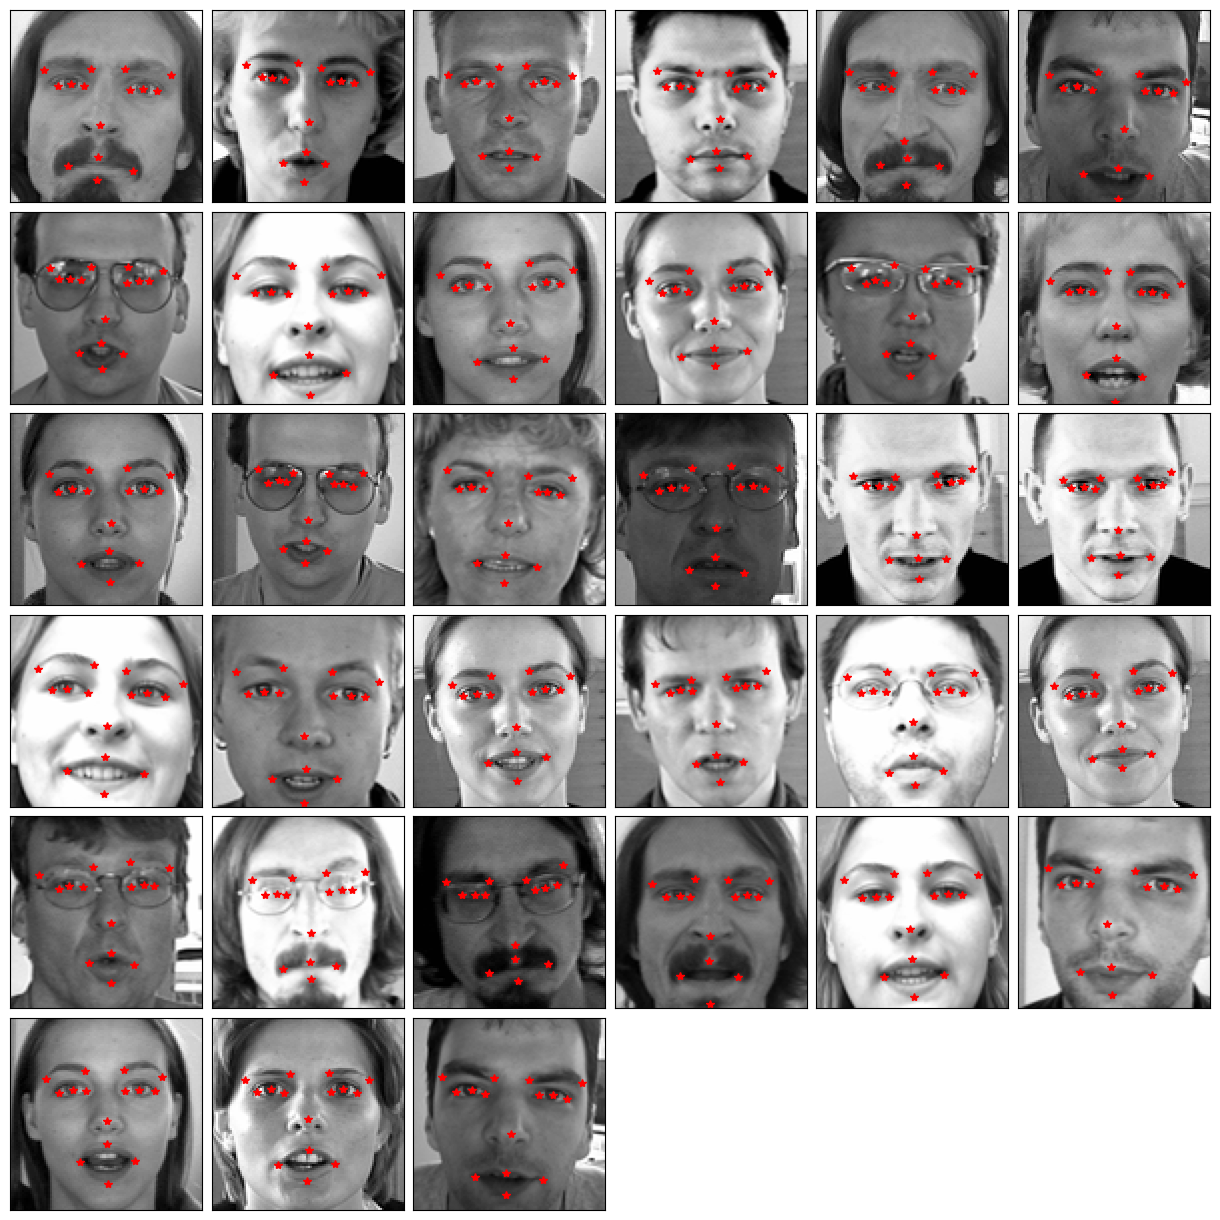

In [29]:
figur = plt.figure(figsize=(12, 12))
figur.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1, 34):
    eks = figur.add_subplot(6, 6, i, xticks=[], yticks=[])
    image_with_keypoints(x, i-1)  # indeks 0'dan başladığı için i-1
plt.show()

In [30]:
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=(96, 96, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout katmanını ekleyin ve model'e eklediğinizden emin olun
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout katmanını ekleyin ve model'e eklediğinizden emin olun
model.add(Dense(64, activation='relu'))
model.add(Dense(30))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 30)                1

In [32]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'accuracy'])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping: Eğitimi erken durdurmak için kullanılabilir
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğit
history = model.fit(x, y, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
177/177 [==============================] - 6s 22ms/step - loss: 560.4497 - mae: 17.5865 - accuracy: 0.2160 - val_loss: 232.5949 - val_mae: 12.4615 - val_accuracy: 0.6482
Epoch 2/100
177/177 [==============================] - 5s 28ms/step - loss: 243.2715 - mae: 11.9427 - accuracy: 0.3066 - val_loss: 578.8446 - val_mae: 21.9020 - val_accuracy: 0.6872
Epoch 3/100
177/177 [==============================] - 4s 20ms/step - loss: 210.3466 - mae: 11.0649 - accuracy: 0.3580 - val_loss: 758.9381 - val_mae: 25.4398 - val_accuracy: 0.6496
Epoch 4/100
177/177 [==============================] - 4s 20ms/step - loss: 188.7435 - mae: 10.4484 - accuracy: 0.4002 - val_loss: 782.4776 - val_mae: 25.8163 - val_accuracy: 0.6872
Epoch 5/100
177/177 [==============================] - 4s 23ms/step - loss: 170.7980 - mae: 9.8802 - accuracy: 0.4478 - val_loss: 605.1890 - val_mae: 22.4331 - val_accuracy: 0.6872
Epoch 6/100
177/177 [==============================] - 5s 27ms/step - loss: 165.5639 - mae:

In [34]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), input_shape=(img_height, img_width, 1),
                activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(30))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 128)       1280      
                                                                 
 batch_normalization (Batch  (None, 96, 96, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                      

In [35]:
#model.compile(optimizer='Adam',  metrics=[RootMeanSquaredError(), 'accuracy'], loss='mae')
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'accuracy'])

Bu kod, bir derin öğrenme modelinin derleme (compile) işlemi için kullanılır. Derleme işlemi, modelin eğitim öncesi yapılandırılması anlamına gelir ve modelin nasıl eğitileceğini belirler. Aşağıda bu kodun yapılandırma adımlarını açıklıyorum:

- `optimizer='Adam'`: Optimizasyon algoritmasını belirler. Adam, yaygın olarak kullanılan bir optimizasyon algoritmasıdır. Optimizasyon algoritması, modelin ağırlıklarını günceller ve eğitim sırasında minimuma yaklaşmasını sağlar.

- `metrics=[RootMeanSquaredError(), 'accuracy']`: Eğitim sırasında takip edilecek performans metriklerini belirler. Burada iki metrik kullanılmıştır. Birincisi 'RootMeanSquaredError', yani kök ortalama karesel hata, ikincisi ise 'accuracy', yani doğruluk oranı. Bu metrikler, modelin ne kadar iyi performans gösterdiğini değerlendirmek için kullanılır.

- `loss='mae'`: Kayıp fonksiyonunu belirler. 'mae' (Mean Absolute Error), ortalama mutlak hata demektir. Modelin tahminlerinin gerçek değerlerden ne kadar uzak olduğunu ölçer. Model, eğitim sırasında bu hatayı minimize etmeye çalışır.

Sonuç olarak, bu kod, modelin eğitimini başlatmadan önce kullanılacak optimizasyon algoritması, performans metrikleri ve kayıp fonksiyonunu belirler. Bu ayarlamalar, modelin başarılı bir şekilde eğitilmesi için önemlidir.

In [37]:
#history = model.fit(x,y,epochs = 30, batch_size = 32,validation_split = 0.2)
history = model.fit(x, y, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
177/177 [==============================] - 583s 3s/step - loss: 48.6483 - mae: 5.4309 - accuracy: 0.3611 - val_loss: 551.8339 - val_mae: 21.6885 - val_accuracy: 0.5511
Epoch 2/10
177/177 [==============================] - 562s 3s/step - loss: 35.6362 - mae: 4.5990 - accuracy: 0.4109 - val_loss: 397.0034 - val_mae: 18.3297 - val_accuracy: 0.6752
Epoch 3/10
177/177 [==============================] - 567s 3s/step - loss: 30.1057 - mae: 4.2021 - accuracy: 0.4595 - val_loss: 97.8848 - val_mae: 8.9431 - val_accuracy: 0.6702
Epoch 4/10
177/177 [==============================] - 564s 3s/step - loss: 27.4025 - mae: 3.9832 - accuracy: 0.4751 - val_loss: 8.3688 - val_mae: 2.0143 - val_accuracy: 0.6730
Epoch 5/10
177/177 [==============================] - 565s 3s/step - loss: 24.7066 - mae: 3.7535 - accuracy: 0.5098 - val_loss: 12.0510 - val_mae: 2.6862 - val_accuracy: 0.6801
Epoch 6/10
177/177 [==============================] - 558s 3s/step - loss: 23.9882 - mae: 3.6837 - accuracy: 0.5

Bu kod, derin öğrenme modelini eğitmek için kullanılır. İşte bu kodun ayrıntılı açıklaması:

- `%%time`: Bu, hücredeki kodun çalışma süresini ölçen ve yazdıran bir Jupyter Notebook hücresi sihirli komutudur.

- `history = model.fit(x, y, epochs=50, batch_size=32, validation_split=0.2)`: Bu satırda modelin eğitimi gerçekleştirilir.
  - `x`: Eğitim verilerini ifade eder.
  - `y`: Etiketleri (hedef değerleri) ifade eder.
  - `epochs=50`: Tüm eğitim verilerinin model tarafından kullanılma sayısını belirten bir epoch sayısı. Model, her epoch'ta veri kümesini kullanarak eğitilir.
  - `batch_size=32`: Ağı güncellerken kullanılan örnek sayısıdır. Mini-batch gradient descent kullanılarak model eğitilecektir ve bu, her iterasyonda kullanılacak örnek sayısını belirtir.
  - `validation_split=0.2`: Verinin yüzde 20'sini doğrulama (validation) için kullanır. Model eğitilirken bu doğrulama verisi kullanılarak modelin genelleme performansı değerlendirilir.

Eğitim işlemi sırasında, modelin her bir epoch'ta eğitim verilerine göre performansı ve doğrulama verilerine göre performansı kaydedilir. Bu bilgileri içeren bir "history" nesnesi döndürülür. Bu nesne, eğitim sürecinin grafiğini çizmek veya eğitim sonuçlarını incelemek gibi çeşitli analizler için kullanılabilir. Bu tür analizler, modelin eğitim verilerine nasıl uyum sağladığını ve genelleme yeteneğini değerlendirmenize yardımcı olabilir.

In [38]:
print("Eğitim Kayıp (Loss):", history.history['loss'])
print("Eğitim MAE:", history.history['mae'])
print("\nDoğrulama Kaybı (Validation Loss):", history.history['val_loss'])
print("Doğrulama MAE:", history.history['val_mae'])

Eğitim Kayıp (Loss): [48.64833068847656, 35.636173248291016, 30.105676651000977, 27.402462005615234, 24.70656967163086, 23.988168716430664, 23.448827743530273, 21.12510871887207, 19.861234664916992, 19.41240882873535]
Eğitim MAE: [5.430867671966553, 4.598982810974121, 4.202051162719727, 3.983158588409424, 3.7534730434417725, 3.683659553527832, 3.634330987930298, 3.425238847732544, 3.3209691047668457, 3.264962673187256]

Doğrulama Kaybı (Validation Loss): [551.8339233398438, 397.00335693359375, 97.88477325439453, 8.368756294250488, 12.051012992858887, 58.35059356689453, 35.49351119995117, 28.685190200805664, 23.659921646118164, 44.7611083984375]
Doğrulama MAE: [21.68854522705078, 18.329708099365234, 8.943062782287598, 2.0143191814422607, 2.686176061630249, 6.589543342590332, 5.137222766876221, 4.3804426193237305, 4.021971225738525, 5.831414699554443]


In [39]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'accuracy', 'val_loss', 'val_mae', 'val_accuracy'])


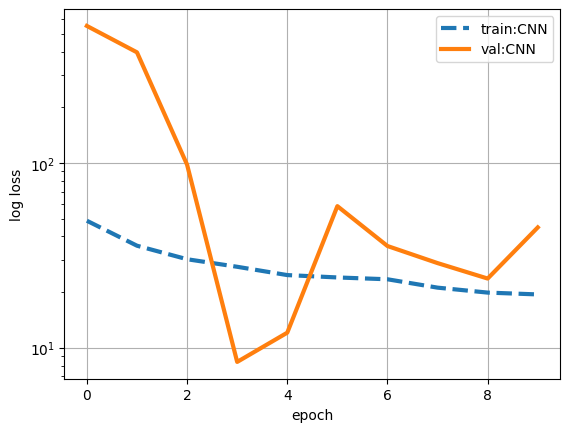

In [40]:
def plot_loss(history, name, plt):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(loss, "--", linewidth=3, label="train:" + name)
    plt.plot(val_loss, linewidth=3, label="val:" + name)

# history.history yerine sadece history olarak kullanılacak
plot_loss(history, "CNN", plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

Bu kodun amacı, eğitim sürecindeki kayıp (loss) değerlerini ve doğrulama sürecindeki kayıp değerlerini grafikle görselleştirmektir. İşte kodun ayrıntılı açıklaması:

- `plot_loss` fonksiyonu: Bu fonksiyon, eğitim sürecindeki ve doğrulama sürecindeki kayıp değerlerini çizmek için kullanılır.

  - `hist`: Eğitim sürecinin geçmişini içeren bir sözlük.
  - `name`: Çizilecek kayıp değerlerinin adını belirten bir string.
  - `plt`: Matplotlib kütüphanesinin bir alt kümesi olan pyplot nesnesi.

- `loss = hist['loss']`: Eğitim sürecindeki kayıp değerlerini içeren listeyi alır.
- `val_loss = hist['val_loss']`: Doğrulama sürecindeki kayıp değerlerini içeren listeyi alır.

- `plt.plot(loss,"--",linewidth=3,label="train:"+name)`: Eğitim kayıp değerlerini çizer. "--" ile kesikli bir çizgi kullanılır. Etiket (label) olarak "train" ve `name` değeri kullanılır.
- `plt.plot(val_loss,linewidth=3,label="val:"+name)`: Doğrulama kayıp değerlerini çizer. Etiket olarak "val" ve `name` değeri kullanılır.

- `plt.legend()`: Grafikteki çizgilerin anlamlarını gösteren bir açıklama (legend) ekler.
- `plt.grid()`: Bir ızgara ekler.
- `plt.yscale("log")`: Y eksenini logaritmik ölçekte ayarlar. Bu, kayıp değerlerinin daha geniş bir aralıkta görülebilmesini sağlar.
- `plt.xlabel("epoch")`: X ekseninin etiketini belirler.
- `plt.ylabel("log loss")`: Y ekseninin etiketini belirler.
- `plt.show()`: Grafikleri gösterir.

Açıklama:
Bu grafik, her epoch'ta eğitim ve doğrulama kayıplarının nasıl değiştiğini gösterir. Eğitim kaybı, modelin eğitim verilerine ne kadar iyi uyum sağladığını, doğrulama kaybı ise modelin genelleme yeteneğini temsil eder. Eğitimdeki düşüşlere karşın doğrulama kaybındaki artışlar, modelin aşırı uyum (overfitting) yaşayabileceğini gösterebilir. Bu grafiği inceleyerek, modelin performansını değerlendirebilir ve eğitim stratejilerinizi ayarlayabilirsiniz.

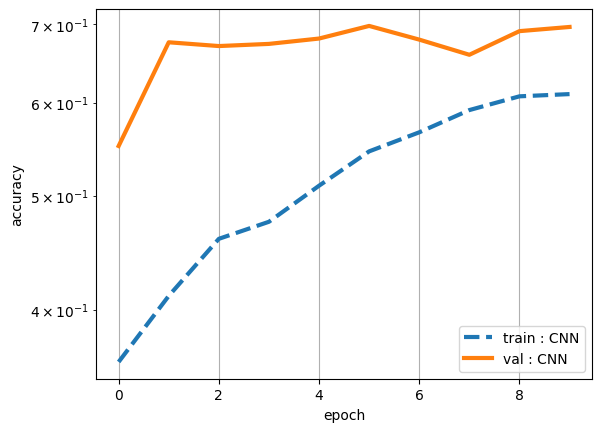

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(acc, "--", linewidth=3, label="train : CNN")
plt.plot(val_acc, linewidth=3, label="val : CNN")
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

Bu kod, eğitim süreci boyunca elde edilen doğruluk (accuracy) değerlerini ve doğrulama (validation) süreci boyunca elde edilen doğruluk değerlerini çizdirir.

- `history.history['accuracy']`: Her epoch sonunda eğitim setinde elde edilen doğruluk değerlerini içeren bir listedir.
- `history.history['val_accuracy']`: Her epoch sonunda doğrulama setinde elde edilen doğruluk değerlerini içeren bir listedir.

Bu iki değer, modelin eğitim ve doğrulama setlerinde ne kadar iyi performans gösterdiğini gösterir. `plt.plot` komutlarıyla çizilen çizgiler, her epoch'taki doğruluk değerlerini temsil eder. `plt.legend()` ile grafiğin hangi çizginin hangi seti temsil ettiği açıklanır. `plt.grid()` ile ızgara eklenir, `plt.yscale("log")` ile y ekseninin logaritmik ölçekte olmasını sağlanır ve `plt.xlabel`, `plt.ylabel` ile eksen etiketleri belirlenir. `plt.show()` ile çizim görüntülenir.

Bu grafik, modelin eğitim süreci boyunca ne kadar iyi öğrendiğini ve overfitting (aşırı uydurma) olup olmadığını görmek için kullanılır.

**Test verilerini hazırlıyoruz.**

In [42]:
test_images = []

for i in range(len(dftest)):
    item = np.array(dftest['Image'][i].split(' '), dtype='float')
    item = np.reshape(item, (img_height, img_width, 1))
    item /= 255
    test_images.append(item)

test_img = np.array(test_images, dtype='float')

Bu kod, bir test veri kümesindeki her bir öğenin gri tonlamalı bir görüntü olduğunu varsayar ve bu görüntüyü uygun bir şekilde işleyerek modelin tahminlerine girmeye hazır hale getirir. Kodun adım adım açıklaması şu şekildedir:

1. `test_img` adlı bir boş liste oluşturulur. Bu liste, test veri kümesindeki her bir öğenin işlenmiş gri tonlamalı görüntüsünü içerecek.

2. `for` döngüsü ile test veri kümesindeki her bir öğe üzerinde iterasyon yapılır.

3. Her bir öğe, virgülle ayrılmış sayıları içeren bir dize olarak temsil edilmiş bir görüntüdür. Bu dize, `split(' ')` yöntemi kullanılarak boşluk karakterine göre bölünür ve sayılara dönüştürülür (`dtype='float'` ile).

4. `np.reshape` kullanılarak, her bir öğe, `img_height` ve `img_width` boyutlarına sahip bir diziye dönüştürülür. Bu, gri tonlamalı bir görüntüyü temsil eder.

5. Görüntülerin piksel değerleri 0 ile 255 arasında olabilir, bu nedenle her bir öğe 255'e bölünerek normalize edilir (`item /= 255`).

6. Normalize edilmiş görüntü, `test_img` listesine eklenir.

7. Son olarak, `test_img` liste, `np.array` kullanılarak bir NumPy dizisine dönüştürülür (`np.array(test_images, dtype='float')`). Bu dizi, modelin tahminlerine girmek için kullanılabilir. Ancak, bu satırın sonunda `test_img` yerine `test_img` kullanıldığı bir yazım hatası var. Doğru olması için `test_img` olmalı.

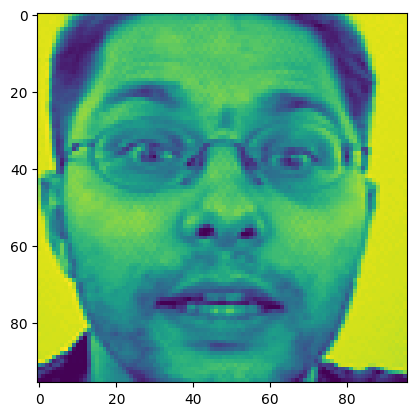

In [43]:
plt.imshow(test_img[0].reshape(96, 96))
plt.show()

**## Test verilerini tahmin edelim**

In [44]:
predict = model.predict(test_img)

56/56 [==============================] - 45s 796ms/step


Bu kod, eğitilmiş bir modeli kullanarak test veri setindeki görüntüler üzerinde tahminlerde bulunur. `model.predict(test_img)` ifadesi, `test_img` adlı test görüntülerini kullanarak modelin çıkışını (tahminleri) alır. Bu tahminler, modelin öğrenmiş olduğu facial keypoints (yüz anahtar noktaları) koordinatlarını içerir.

**# Sonuçları kaydediyoruz**

In [48]:
sublook = pd.read_csv('/content/facial-keypoints-detection/IdLookupTable.csv')

In [49]:
# "sublook" adlı bir DataFrame'deki sütunların özellik isimlerini listeye dönüştürüyoruz
feature_names = list(sublook['FeatureName'])
image_ids = list(sublook['ImageId'] - 1)
row_ids = list(sublook['RowId'])

feature_list = [feature_names.index(feature) for feature in feature_names]

Tabii ki, bu kodun temel amacı, "sublook" adlı bir DataFrame'deki "FeatureName" sütunundaki özellik isimlerini, "ImageId" sütunundaki görüntü kimliklerini ve "RowId" sütunundaki satır kimliklerini listelere dönüştürmektir.

İşlemleri adım adım açıklayalım:

1. `feature_names = list(sublook['FeatureName'])`: "FeatureName" sütunundaki özellik isimlerini içeren listeyi oluşturur.
2. `image_ids = list(sublook['ImageId'] - 1)`: "ImageId" sütunundaki görüntü kimliklerini içeren listeyi oluşturur. Burada, "ImageId" değerlerinden 1 çıkarılarak indeksleme düzeltilir, çünkü indeksler genellikle 0'dan başlar.
3. `row_ids = list(sublook['RowId'])`: "RowId" sütunundaki satır kimliklerini içeren listeyi oluşturur.
4. `feature_list = [feature_names.index(feature) for feature in feature_names]`: "FeatureName" listesindeki her özelliğin indeksini bulur ve bu indeksleri "feature_list" adlı listeye ekler. Bu, her bir özelliğin sırasını "feature_names" listesinde bulunan sıraya göre belirleyerek yapılır.

Bu kod, özellik isimleri, görüntü kimlikleri ve satır kimliklerini listelere dönüştürerek bir veri hazırlama işlemi gerçekleştirir. Bu tür bir hazırlık, genellikle bir modelin tahminlerini uygun satırlara ve sütunlara yerleştirmek için kullanılır.

In [50]:
predictions = [predict[x][y] for x, y in zip(image_ids, feature_list)]

Bu kod parçası, bir döngü kullanarak `predict` adlı bir 2D diziden tahmin değerlerini çıkararak yeni bir listeyi oluşturur. Kodun yapısına göre, bu tahmin değerleri, `image_ids` ve `feature_list` adlı iki listeyi kullanarak `predict` dizisinden çekilir.

Buradaki değişkenlerin anlamları şunlardır:

- `predict`: İki boyutlu bir dizi (matris) olarak düşünülen, her bir satır bir resmin ve her bir sütun ise belirli bir özellik noktasının (feature point) tahmin değerini içeren bir veri yapısı.
- `image_ids`: Resimlerin indekslerini içeren bir liste. Her bir öğe, `predict` dizisindeki bir satırın indeksini temsil eder.
- `feature_list`: Özellik noktalarının indekslerini içeren bir liste. Her bir öğe, `predict` dizisindeki bir sütunun indeksini temsil eder.

Bu list comprehension (liste anlama) yapısı, her bir `(x, y)` çifti için `predict[x][y]` ifadesini hesaplar ve bu değerleri bir liste içinde saklar. Yani, `image_ids` ve `feature_list` listelerinin her bir öğesiyle eşleşen konumdaki tahmin değerlerini içeren bir liste oluşturur.

In [51]:
row_ids = pd.Series(row_ids, name='RowId')
locations = pd.Series(predictions, name='Location')
locations = locations.clip(0.0, 96.0)
submission_result = pd.concat([row_ids, locations], axis=1)
submission_result.to_csv('submission.csv', index=False)

Bu kod, önce tahmin edilen değerleri sınırlayan bir işlem yapıyor (`locations.clip(0.0, 96.0)`). Ardından, tahmin edilen konumları, `row_ids` ve `predictions` listelerinden oluşturulan birer Pandas Serisi olan `RowId` ve `Location` isimli Serilerle birleştiriyor (`pd.concat([row_ids, locations], axis=1)`). Son olarak, bu birleştirilmiş veriyi bir CSV dosyasına (`submission.csv`) kaydediyor (`to_csv('submission.csv', index=False)`).

Bu işlemin amacı, Kaggle yarışmasının gereksinimlerine uygun bir şekilde sonuçları hazırlamak ve sunmak için kullanılan bir format oluşturmaktır. Yarışmaya katılımcılar, modellerinin tahmin ettiği yüz anahtar nokta konumlarını bu formatta bir CSV dosyasına kaydederek sonuçlarını yarışma platformuna yükleyebilirler.

# Sonuç:
Bu yarışma süreci boyunca bir dizi önemli kazanım ve fayda elde ettim. İlk olarak, veri ön işleme aşamasında eksik veya bozuk verileri etkili bir şekilde ele almayı öğrendim. Veri setindeki NaN değerleri uygun bir strateji ile doldurmak ve görüntü verilerini modele uygun hale getirmek, gerçek dünya veri mühendisliği problemlerine yönelik pratik becerilerimi geliştirdi.

Modelin oluşturulması aşamasında, farklı sinir ağı mimarilerini anlama ve uygulama fırsatı buldum. Basitten karmaşığa doğru evrilen bu mimarileri kullanarak, yüz hatları tespiti gibi karmaşık bir görevi çözebilecek modeller inşa etmeyi öğrendim. Ayrıca, hiperparametre ayarlaması ve farklı optimizasyon stratejilerini test etme yeteneği, modelin performansını artırmak için kritik bir rol oynadı.

Eğitim sürecinde, epoch sayısını ve toplu iş boyutunu optimize etme, aşırı uyum problemlerini ele alma ve erken durdurma gibi teknikleri uygulayarak, modelin daha iyi genelleme yapmasını sağlamayı öğrendim. Modelin başarısını değerlendirmek için kayıp fonksiyonları, doğruluk ve kök ortalama karesel hata (RMSE) gibi metrikleri anlamak, modelin performansını ölçmek açısından önemliydi.

Son olarak, modelin tahminlerini sunmaya yönelik bir sonuç dosyası oluşturma ve Kaggle yarışmasına katılma deneyimi, gerçek dünya uygulamalarında makine öğrenimi projelerini nasıl yöneteceğimiz konusunda değerli bir anlayış kazandırdı. Yarışma sürecinde karşılaştığım zorluklar, hatalardan öğrenme ve iyileştirmeler yapma süreci, genel olarak veri bilimi ve derin öğrenme konularındaki yeteneklerimi önemli ölçüde artırdı.